In [1]:
# GIS imports
import rasterio
from rasterio.plot import show

# Plotting imports
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colors
from matplotlib.patches import Ellipse

# Misc imports
import json
from datetime import datetime, timedelta
from pathlib import Path
import numpy as np

In [2]:
# if running notebook to create a large number of plots, set this flag to True
SAVE_PLOT_MODE = False

if SAVE_PLOT_MODE:
    Path('../plots/').mkdir(exist_ok=True)

In [3]:
# This is the path where we have created merged B01 OPERA DSWx data
data_path = Path('../data/B01_mosaics/')
year_paths = [x for x in data_path.glob('2*') if x.is_dir()]

filepaths = []
for p_ in sorted(year_paths):
    filepaths.extend(sorted(list(p_.glob('*.tif'))))

In [4]:
def parse_dict(input_dict):
    datestr = input_dict['t']
    month, day, year = [int(x) for x in datestr.split(" ")[0].split("/")]
    
    date = datetime(year=year, month=month, day=day)
    water_level = float(input_dict['v'])

    return date, water_level

In [5]:
data_file = Path('../data/accumweb_09192023.json')

with open(data_file, 'r') as f:
    data = json.load(f)

dataset = list(map(parse_dict, data['Series'][0]['Data'][:-1])) # the last data entry has a null value for water level, we skip this

x = [entry[0] for entry in dataset]
y = [entry[1] for entry in dataset]

In [6]:
# We have created an HLS mosaic to serve as our basemap
with rasterio.open('../data/hls/2022185_hls_mosaic.tif') as ds:
    hls_mosaic_img = ds.read()

print(hls_mosaic_img.shape)

(3, 6994, 6992)


In [11]:
def generate_plot(filename):
    with rasterio.open(filename) as ds:
        sample_bounds = ds.bounds
        sample_transform = ds.transform
        colormap = ds.colormap(1)
        img = ds.read(1)

    # We want to see only OSW and PSW - set opacity of all other classes to zero
    # Also change PSW to match OSW color scheme
    for key, val in colormap.items():
        if key == 1:
            continue
        if key == 2:
            val = (0, 0, 255, 255)
            colormap[key]=val
            continue

        val = list(val)
        val[3] = 0
        colormap[key] = tuple(val)

    cmap = ListedColormap([np.array(colormap[key]) / 255 for key in range(256)])
    bounds =  [0, 1, 2, 3, 251, 252, 253, 254]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    # parse date
    yyyymmdd = filename.with_suffix('').name
    year = int(yyyymmdd[:4])
    month = int(yyyymmdd[4:6])
    day = int(yyyymmdd[6:])

    date = datetime(year=year, month=month, day=day)

    # initialize plot
    fig, ax = plt.subplots(figsize=(24, 22))

    ### main plot
    show(hls_mosaic_img*3e-4, transform=sample_transform, ax=ax)
    show(img, cmap=cmap, transform=sample_transform, ax=ax)

    ax.set_xlim(6.9e5, 7.7e5)
    ax.set_ylim(3.98e6, 4.05e6)
    ax.set_xlabel('Eastings (meters)', fontsize=15)
    ax.set_ylabel('Northings (meters)', fontsize=15)
    ax.ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
    ax.set_title(f"Lake Mead Surface Water Extent 2014 - 2023", fontsize=20, y=-0.075)

    ax.annotate(f"{date.strftime('%d %B %Y')}", xy=(0.02, 0.95), xycoords='axes fraction', fontsize=30, color='black', weight='bold')
    ax.grid()

    ### Plot zoomed inset
    x1, x2, y1, y2 = 7.31e5, 7.395e5, 4.02e6, 4.038e6  # subregion of the original image
    axins = ax.inset_axes([0.78, 1.07, 0.25, 0.45], xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])

    show(hls_mosaic_img*3e-4, ax=axins, transform=sample_transform)
    show(img, cmap=cmap, ax=axins, transform=sample_transform)

    ax.indicate_inset_zoom(axins, edgecolor="black", linewidth=4, alpha=0.9)
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    for axis in ['top','bottom','left','right']:
        axins.spines[axis].set_linewidth(3)
        axins.spines[axis].set_color('black')


    ### Plot line-plot of Lake Mead water height
    inset_axes = ax.inset_axes([0.0, 1.07, 0.78, 0.45])
    inset_axes.plot(x, y)
    inset_axes.set_xlim(datetime(year=2012, month=1, day=1), datetime(year=2024, month=1, day=1))
    inset_axes.set_ylim([1025, 1150])
    inset_axes.set_ylabel("Water level (feet)", fontsize=14, color='black')


    ylims = inset_axes.get_ylim()
    yticks = inset_axes.get_yticks()
    inset_axes.plot([date, date], ylims, color = 'red')
    water_level = y[np.where([x_ == date for x_ in x])[0][0]]
    inset_axes.set_xticks([datetime(year=x[0], month=x[1], day=x[2]) for x in [(2013, 1, 1), (2014, 1, 1), (2015, 1, 1), (2016, 1, 1), (2017, 1, 1), (2018, 1, 1), (2019, 1, 1), (2020, 1, 1), (2021, 1, 1), (2022, 1, 1), (2023, 1, 1)]])
    inset_axes.set_xticklabels( [x.strftime("%Y") for x in [datetime(year=x[0], month=x[1], day=x[2]) for x in [(2013, 1, 1), (2014, 1, 1), (2015, 1, 1), (2016, 1, 1), (2017, 1, 1), (2018, 1, 1), (2019, 1, 1), (2020, 1, 1), (2021, 1, 1), (2022, 1, 1), (2023, 1, 1)]]], fontsize='xx-large')
    inset_axes.set_xlabel("Year", fontsize=18)
    inset_axes.set_yticklabels(yticks, fontsize='x-large')

    inset_axes.set_title("Lake Mead water level", fontsize=16, weight="bold")
    inset_axes.annotate(f"{water_level}", xy=(date-timedelta(days=360), water_level-15), fontsize=14)
    inset_axes.add_artist(Ellipse((date, water_level), 80, 5, edgecolor="black", fill=False, linewidth=3)) # circle marker to indicate location of intersection

    inset_axes.grid(True)

    plt.tight_layout()
    
    if SAVE_PLOT_MODE:
        plt.savefig(f"../plots/{filename.with_suffix('.png').name}", bbox_inches = 'tight')

    
        plt.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/var/folders/0j/_hzqdqys6wg5g5khfdl7tdk00000gr/T/ipykernel_36028/3662374617.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  inset_axes.set_yticklabels(yticks, fontsize='x-large')


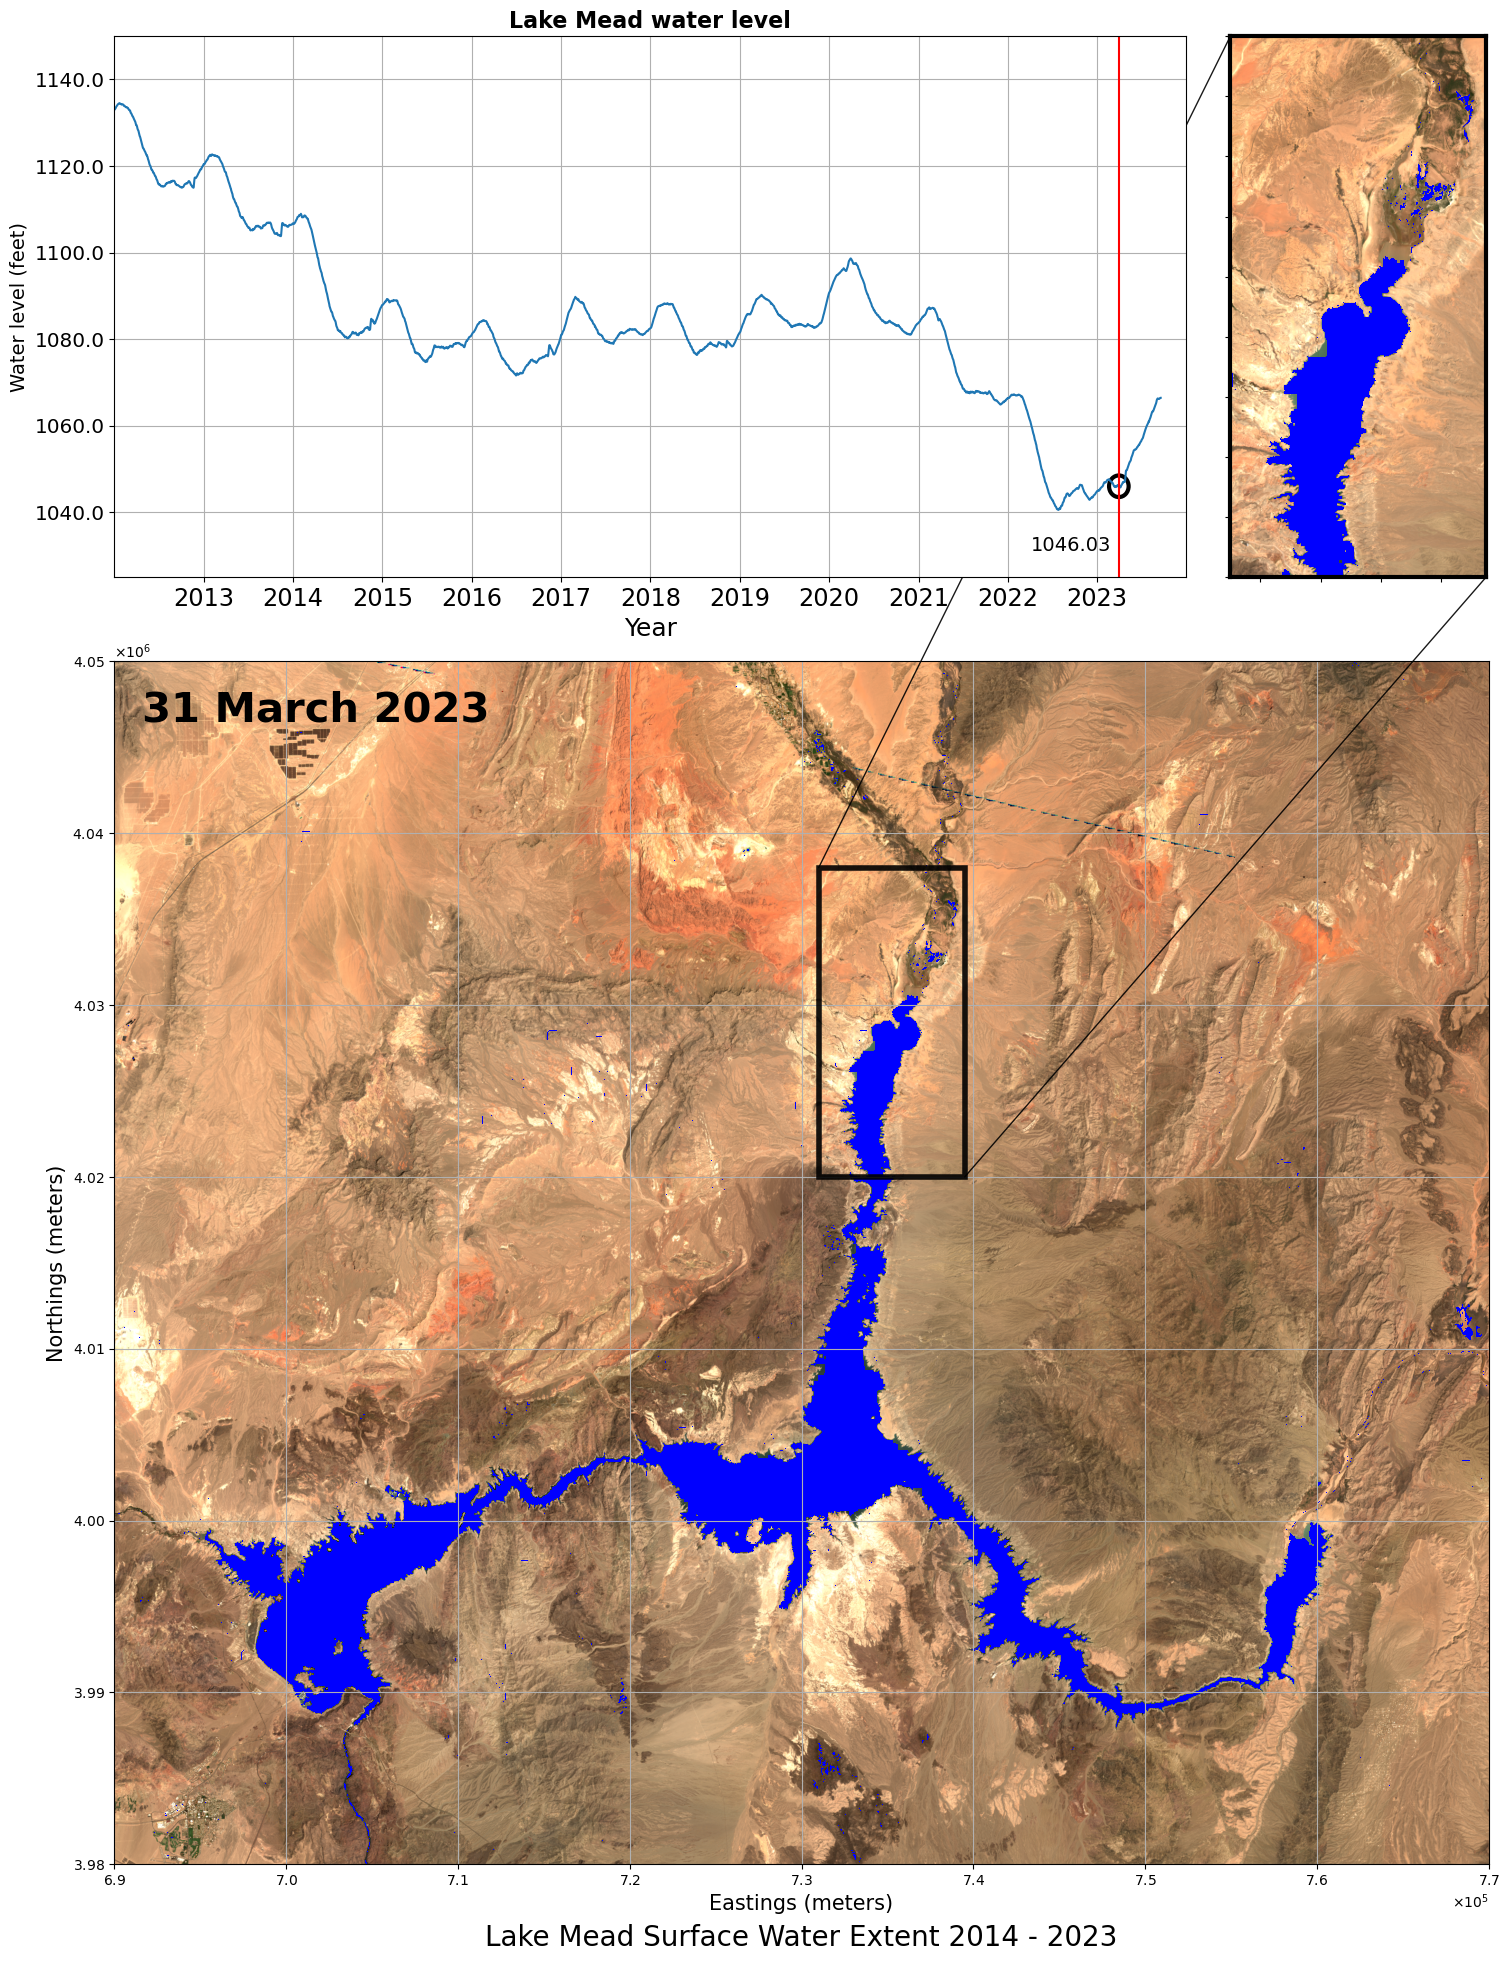

In [12]:
if SAVE_PLOT_MODE:
    plt.ioff()
    # This will process all available DSWx data and generate plots
    _ = list(map(generate_plot, filepaths))
else:
    plt.ion()
_ = list(map(generate_plot, [Path('../data/B01_mosaics/2023/20230331.tif')]))